#### Residential over/undervaluation in the selected European countries

The ECB monitors closely potential overvaluation in RRE markets, employing a set of   
four measures: deviations from their long-term averages of the price-to-income ratio   
and of the price-to-rent ratio, and econometric valuation estimates using an inverted  
demand model and an asset pricing model. In addition, the overvaluation model that   
takes housing market demand and supply into account to assess the state of house   
prices and housing investment relative to their long-term equilibrium.

Calculations behind the estimates: [methodology](https://www.ecb.europa.eu/pub/financial-stability/macroprudential-bulletin/html/ecb.mpbu202210_2~7f1ad6fa2d.en.html)  
Underlying [data](https://data.ecb.europa.eu/data/datasets/RESV/structure)

In [1]:
import pandas as pd
import pandasdmx as sdmx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import itertools
from tqdm import tqdm
from tenacity import retry, stop_after_attempt, wait_fixed
from requests.exceptions import HTTPError, ConnectionError

# settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Create a request instance for the ECB
ecb = sdmx.Request('ECB')
dataflow_id = 'RESV'

# Create required combinations
valuation_methods = ['RVAV', 'RVMA', 'RVMI']
countries = ["AT", "BE", "BG", "CY", "CZ", "DE", "DK", "EE", "ES", 
             "FI", "FR", "GB", "GR", "HR", "HU", "IE", "IT", "LT", 
             "LU", "LV", "MT", "NL", "PL", "PT", "RO", "SE", "SI", "SK"]
re_type = ['XTR', '_TR', 'RTF', 'XTF', 'XTR']

combinations = list(itertools.product(valuation_methods, countries, re_type))

# Container for results
results = pd.DataFrame()

for method, country, real_estate_type in tqdm(combinations):
    series_key = f'Q.{country}._T.N.{real_estate_type}.{method}.4F0._Z._Z.PT'

    try:
        # Retrieve the data
        data_response = ecb.data(dataflow_id, key=series_key)
        df = data_response.to_pandas().reset_index()
    
        results = pd.concat([results, df])

    except HTTPError as err:
        if err.response.status_code != 404:
            print(f"Non 404 error for {real_estate_type, country}: {err}")
            
    except Exception as e:
        print(f"Non-HTTP error for {real_estate_type, country}: {e}")

results.head()

 76%|████████████████████████████████████████████████████████████▉                   | 320/420 [01:22<00:23,  4.26it/s]

Non-HTTP error for ('XTF', 'EE'): ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


100%|████████████████████████████████████████████████████████████████████████████████| 420/420 [01:46<00:00,  3.95it/s]


,FREQ,REF_AREA,REGION,ADJUSTMENT,PROPERTY_TYPE,INDICATOR,DATA_PROVIDER,PRICE_TYPE,TRANSFORMATION,UNIT_MEASURE,TIME_PERIOD,value
0,Q,AT,_T,N,_TR,RVAV,4F0,_Z,_Z,PT,2007-Q1,-13.50
1,Q,AT,_T,N,_TR,RVAV,4F0,_Z,_Z,PT,2007-Q2,-12.75
2,Q,AT,_T,N,_TR,RVAV,4F0,_Z,_Z,PT,2007-Q3,-12.75
3,Q,AT,_T,N,_TR,RVAV,4F0,_Z,_Z,PT,2007-Q4,-14.25
4,Q,AT,_T,N,_TR,RVAV,4F0,_Z,_Z,PT,2008-Q1,-17.00


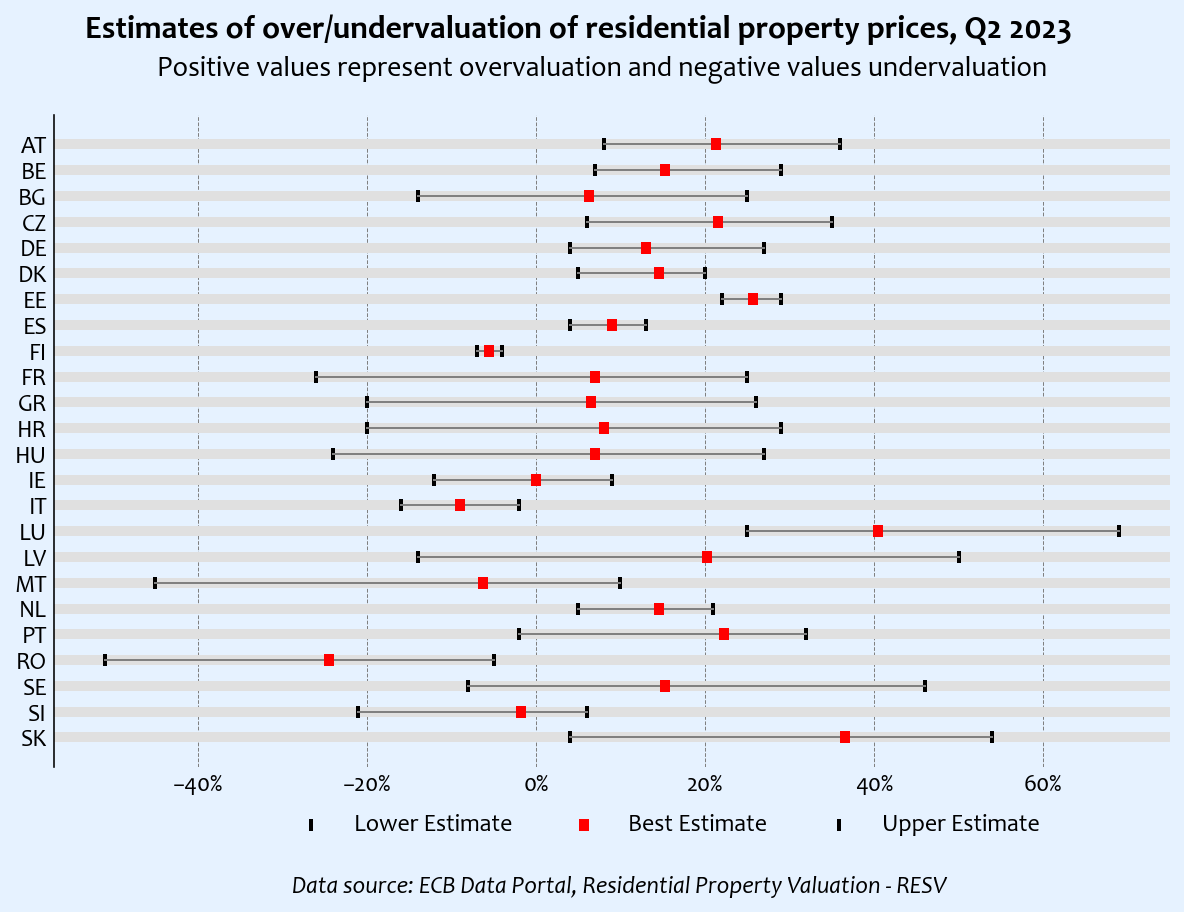

In [3]:
# Calculate min, max, and 50th percentile for each country
res2 = results.copy()
res2['value'] = res2['value'] / 100
agg_functions = {'value': ['min', 'max', lambda x: np.percentile(x, 50)]}
df2 = res2[res2['TIME_PERIOD'] == '2023-Q2'].groupby('REF_AREA').agg(agg_functions)

# Rename the columns for convenience
df2.columns = ['Min', 'Max', '50th Perc']
df2 = df2.reset_index()
df2 = df2.sort_values(by='REF_AREA', ascending=False)

# Create graph
color = '#e6f2ff'
fig = plt.figure(figsize=(10, 6), facecolor='darkgrey')
ax1 = fig.add_subplot(111)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Drawing lines between Min and Max for each REF_AREA
for _, row in df2.iterrows():
    ax1.plot([row['Min'], row['Max']], [row['REF_AREA'], row['REF_AREA']], 'gray', lw=1)

def scatter_fun(df, var, label, plot_color, width):
    return ax1.scatter(df[var], 
                       df['REF_AREA'], 
                       linewidths=width, 
                       alpha=1., 
                       c=plot_color, 
                       marker="|", 
                       label=label)

scatter_fun(df2, 'Min', 'Lower Estimate', 'black', 2)
scatter_fun(df2, '50th Perc', 'Best Estimate', 'red', 5).set_zorder(3)
scatter_fun(df2, 'Max', 'Upper Estimate', 'black', 2)

ax1.yaxis.grid(True, color='#e0e0e0', linewidth=5)
ax1.xaxis.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
legend = ax1.legend(loc=[0.2, -0.12], facecolor=color, edgecolor=color, ncol=3, fontsize=12)
ax1.set_axisbelow(True)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(axis='both', which='both', length=0)

fig.patch.set_facecolor(color)
ax1.set_facecolor(color=color)
ax1.set_axisbelow(True)

# Reduce the font size of country names
for label in ax1.get_yticklabels():
    label.set_fontsize(12)
    label.set_fontname('Candara')

for label in ax1.get_xticklabels():
    label.set_fontsize(12)
    label.set_fontname('Candara')

for text in legend.get_texts():
    text.set_fontname('Candara')

plt.title('Estimates of over/undervaluation of residential property prices, Q2 2023', 
          fontsize=16, 
          x=0.47, 
          y=1.1, 
          fontname='Candara', 
          fontweight='bold')

# Example texts (modify as needed)
ax1.text(0.89, 1.05, 
         'Positive values represent overvaluation and negative values undervaluation',
         verticalalignment='bottom', 
         horizontalalignment='right',
         transform=ax1.transAxes,
         color='black', 
         fontname='Candara', 
         fontsize=14)

ax1.text(0.8, -0.2, 
         'Data source: ECB Data Portal, Residential Property Valuation - RESV',
         verticalalignment='bottom', 
         horizontalalignment='right',
         transform=ax1.transAxes,
         color='black', 
         style='italic',
         fontname='Candara', 
         fontsize=12)

plt.savefig('ecb_real_estate.png', bbox_inches='tight', dpi=300)
plt.show()